# Curate results of spike sorting

Notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- 2-curate_acoustics
- 3-sort_spikes
- **4-curate_spikes**

Use the environment **spikeproc** to run this notebook

If necessary, SpikeInterface has a [method](https://spikeinterface.readthedocs.io/en/stable/modules/sorters.html) to concatenate multi-segment recordings 

In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import spikeinterface.full as si

## Set parameters

In [2]:
sess_par = {
    'bird':'z_c5o30_23', # bird ID
    'sess':'2023-06-15', # session date
    'epoch':'0913_g0', # epoch
    'ephys_software':'sglx', # recording software, sglx or oe
    'sorter':'kilosort3', # spike sorting algorithm
    'sort':'sort_0', # sort index
}

labels = ['sua','mua','noise','1','2','3']

In [3]:
sort_dir = '/mnt/cube/chronic_ephys/der/{}/{}/{}/{}/{}/{}/'.format(sess_par['bird'],sess_par['sess'],sess_par['ephys_software'],sess_par['epoch'],sess_par['sorter'],sess_par['sort'])
sort_path = sort_dir + 'sorter_output/'
wave_path = sort_dir + 'waveforms/'
metrics_path = wave_path + 'quality_metrics/metrics.csv'
print(sort_dir)

/mnt/cube/chronic_ephys/der/z_c5o30_23/2023-06-15/sglx/0913_g0/kilosort3/sort_0/


In [4]:
sort = si.read_kilosort(sort_path)
wave = si.load_waveforms(wave_path)

In [5]:
metrics_pd = pd.read_csv(metrics_path)
metrics_list = metrics_pd.keys().tolist()
for this_metric in metrics_list:
    sort.set_property(this_metric, metrics_pd[this_metric].values)
print(sort)
print(wave)
# si.plot_probe_map(wave)

KiloSortSortingExtractor: 337 units - 1 segments - 30.0kHz
WaveformExtractor: 384 channels - 337 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


## Curate spikes
Using the [SpikeInterface](https://spikeinterface.readthedocs.io/en/latest/) [web-based](https://github.com/SpikeInterface/spikeinterface) [viewer](https://github.com/magland/sortingview), using this [curation guide](https://docs.google.com/document/d/1IUQBDqT2FJ8xv-ZPQRcb4yFb-ptSh8GtmOEt0uaAESc/edit?usp=sharing)

In [6]:
si.plot_quality_metrics(wave, skip_metrics=['snr','amplitude_cutoff'], backend="sortingview");

https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://a7286c90ad8990c421a37ef4c7e1cd822f4a60ec&label=SpikeInterface%20-%20Quality%20Metrics


In [ ]:
label_choices = ['sua_1','sua_2','sua_3','mua_4','noise']
pss = si.plot_sorting_summary(waveform_extractor=wave,curation=True,backend='sortingview',
                              unit_table_properties=unit_table_properties,label_choices=label_choices)

In [7]:
si.plot_sorting_summary(waveform_extractor=wave, curation=True, backend='sortingview', label_choices=labels);

Computing sha1 of /home/AD/lostrows/.kachery-cloud/tmp_AdQ0ZndH/file.dat
https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://9262821271be5099a80e9742870e46f5f8e7e69a&label=SpikeInterface%20-%20Sorting%20Summary


## Import curated sorts
When complete, click the button labeled `Save as snapshot (sha1://)` and paste the link below to generate sort_curated, a [sorting](https://spikeinterface.readthedocs.io/en/latest/api.html#spikeinterface.core.BaseSorting) [object](https://github.com/SpikeInterface/spikeinterface/blob/25bb836601e3ec358a06dcb73be34699d8065faf/src/spikeinterface/core/basesorting.py)

In [8]:
sha_uri = 'sha1://6f9c87111f25d51ca3c3dfb055f246091c16a7fc'

In [9]:
%%capture cap
sort_curated = si.apply_sortingview_curation(sorting=sort,uri_or_json=sha_uri,verbose=True)

In [52]:
def find(ch, string1):
    return [i for i in range(len(string1)) if string1[i]==ch]

In [75]:
# get unit IDs
unit_ids = sort_curated.get_unit_ids()
print(f"{len(unit_ids)} units after curation:")

# get merged units
merge_str_all = cap.stdout
merge_starts = find('[',merge_str_all)
merge_stops = find(']',merge_str_all)
merges = [merge_str_all[merge_starts[i]+1:merge_stops[i]].split(',') for i in range(len(merge_starts))]
iui = sort.get_unit_ids() # initial unit IDs
utm = [[int(x) for x in m] for m in merges] # units to merge
nui = np.arange(max(iui)+1, max(iui)+len(utm)+1) # new unit IDs

# set merged properties to unit with highest original spike rate
orig_unit_ids = [[x] for x in unit_ids]
for i, u in enumerate(utm):
    print(f'- Units {u} merged to {nui[i]}')
    idx = [np.where(iui == i)[0][0] for i in u]
    u_n_spks = sort.get_property('num_spikes')[idx]
    max_spikes_i = idx[np.argmax(u_n_spks)]
    nui_i = np.where(unit_ids == nui[i])[0][0]
    for this_metric in metrics_list:
        sort_curated.get_property(this_metric)[nui_i] = sort.get_property(this_metric)[max_spikes_i]
    sort_curated.get_property('num_spikes')[nui_i] = np.sum(u_n_spks)
    orig_unit_ids[nui_i] = u

334 units after curation:
- Units [359, 362] merged to 363
- Units [355, 357, 358] merged to 364


## Create sorted spikes dataframe
Handle sorting object following the how-to guide outlined [here](https://github.com/SpikeInterface/spikeinterface/blob/25bb836601e3ec358a06dcb73be34699d8065faf/doc/how_to/get_started.rst)

In [84]:
# make sort dataframe
spk_df = pd.DataFrame({'unit': unit_ids})

# retrieve spike trains
spk_df['spike_train'] = spk_df['unit'].apply(lambda x: sort_curated.get_unit_spike_train(unit_id=x, segment_index=0))

# store sort properties
for prop in sort_curated.get_property_keys():
    spk_df[prop] = sort_curated.get_property(prop)
spk_df = spk_df.drop(columns=['original_cluster_id'])
spk_df['orig_unit'] = orig_unit_ids
spk_df = spk_df.rename(columns={'sua': 'label_sua',
                                '1': 'label_1',
                                '2': 'label_2',
                                '3': 'label_3',
                                'mua': 'label_mua',
                                'noise': 'label_noise'})

In [86]:
spk_df.tail(3)

,unit,spike_train,ContamPct,Amplitude,KSLabel,KSLabel_repeat,Unnamed: 0,num_spikes,firing_rate,presence_ratio,...,silhouette,nn_hit_rate,nn_miss_rate,label_mua,label_3,label_sua,label_1,label_2,label_noise,orig_unit
331,361,"[312813, 313047, 999492, 999621, 999795, 10005...",100.0,6.348000e+03,good,good,361,465.0,0.063336,0.696721,...,0.503618,0.952688,0.001513,True,False,True,False,True,False,[361]
332,363,"[3199, 12586, 14561, 18051, 22243, 25928, 3169...",100.0,6.920613e-310,None,None,362,85963.0,11.556394,1.000000,...,0.312170,0.922500,0.004480,False,False,False,False,False,False,"[359, 362]"
333,364,"[157814, 158164, 159133, 174304, 193314, 21101...",100.0,6.920613e-310,mua,mua,357,7573.0,0.641258,1.000000,...,0.488429,0.898464,0.001056,False,False,False,False,False,False,"[355, 357, 358]"


In [132]:
sort_curated = si.apply_sortingview_curation(sorting=sort, uri_or_json=sha_uri)
utm = sort_curated.to_dict()['kwargs']['units_to_merge']
nui = sort_curated.to_dict()['kwargs']['new_unit_ids']
print('Merge summary:')
for i, u in enumerate(utm):
    print(f"- Units {u} will be merged to new unit {nui[i]}")

Merge summary:
- Units [282, 285, 286] will be merged to new unit 364


In [103]:
# get unit IDs
unit_ids = sort_curated.get_unit_ids()
print(f"{len(unit_ids)} units after curation")

334 units after curation


In [175]:
# get number of segments (1 if no additional recordings were concatenated)
num_seg = sort_curated.get_num_segments()
if num_seg>1: print(f"{num_seg} segments")

In [171]:

spk_df = pd.DataFrame({'unit': unit_ids})


spk_df['spike_train'] = spk_df['unit'].apply(lambda x: sort_curated.get_unit_spike_train(unit_id=x, segment_index=0))

# retrieve labels
for label in labels:
    spk_df['label_'+label] = sort_curated.get_property(label)

# store original units (before merging)
spk_df['orig_unit'] = spk_df['unit'].apply(lambda x: utm[nui.index(x)] if x in nui else x)

In [174]:
spk_df.tail(3)

,unit,spike_train,label_sua,label_mua,label_noise,label_1,label_2,label_3,orig_unit
331,362,"[3199, 12586, 14561, 18051, 22243, 25928, 3169...",False,False,True,False,False,False,362
332,363,"[27870725, 101721970, 101722221, 101731678, 10...",False,False,True,False,False,False,363
333,364,"[101416727, 101719009, 101732652, 152530230, 1...",False,False,True,False,False,False,"[282, 285, 286]"


## Save curated spikes

In [ ]:
with open(os.path.join(sort_dir, 'spk_df.pickle'), 'wb') as handle:
    pickle.dump(spk_df, handle)

### Visualize spike raster for an example bout

In [294]:
import os
import pickle
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

In [398]:
# load bout dataframe
bouts_dir = '/mnt/cube/chronic_ephys/der/{}/{}/{}/{}/'.format(sess_par['bird'],sess_par['sess'],sess_par['ephys_software'],sess_par['epoch'])
with open(os.path.join(bouts_dir, 'bout_pd_ap0_curated.pkl'), 'rb') as handle:
    bout_df = pickle.load(handle)

In [417]:
# retrieve bout info
bout_idx = 5
if bout_df.loc[bout_idx, 'bout_check']:
    waveform = bout_df.loc[bout_idx, 'waveform']
    spectrogram = bout_df.loc[bout_idx, 'spectrogram']
    len_ms = bout_df.loc[bout_idx, 'len_ms']
    start_sample_ap = bout_df.loc[bout_idx, 'start_sample_ap_0']
    bout_fs = bout_df.loc[bout_idx, 'sample_rate']
    fs = sort_curated.get_sampling_frequency()
    print('Bout loaded...')

Bout loaded.


In [418]:
# retrieve spike trains
def make_raster(spk_df, unit_ids, start_sample, end_sample):
    spk_arr = np.zeros((len(unit_ids), int(end_sample - start_sample)))
    
    for i, unit_id in enumerate(unit_ids):
        unit_spk_t = spk_df.loc[spk_df['unit'] == unit_id, 'spike_train'].iloc[0]
        unit_spk_t = unit_spk_t[(unit_spk_t > start_sample) & (unit_spk_t < end_sample)]
        spk_arr[i, (unit_spk_t - start_sample).astype(int)] = 1
    
    return spk_arr

# make spike raster for plotting
trail_front = 1
trail_end = 1
start_idx = start_sample_ap - (fs * trail_front)
end_idx = start_sample_ap + len_ms/1000*fs + (fs * trail_front)
spike_arr = make_raster(spk_df, spk_df.unit.to_list(), start_idx, end_idx)

In [419]:
def make_spec(x, fs, n_window=512, step_ms=1, f_min=100, f_max=9000, cut_off=0.000055):
    msec_samples = int(fs * 0.001)
    n_overlap = n_window - msec_samples * step_ms
    sigma = 1 / 200. * fs
    
    f, t, sxx = signal.spectrogram(x, fs,
                                   nperseg=n_window,
                                   noverlap=n_overlap,
                                   window=signal.gaussian(n_window, sigma),
                                   scaling='spectrum')
    
    if cut_off > 0:
        sxx[sxx < np.max((sxx) * cut_off)] = 1
    
    sxx[f<f_min, :] = 1

    return f[(f>f_min) & (f<f_max)], t, sxx[(f>f_min) & (f<f_max)]

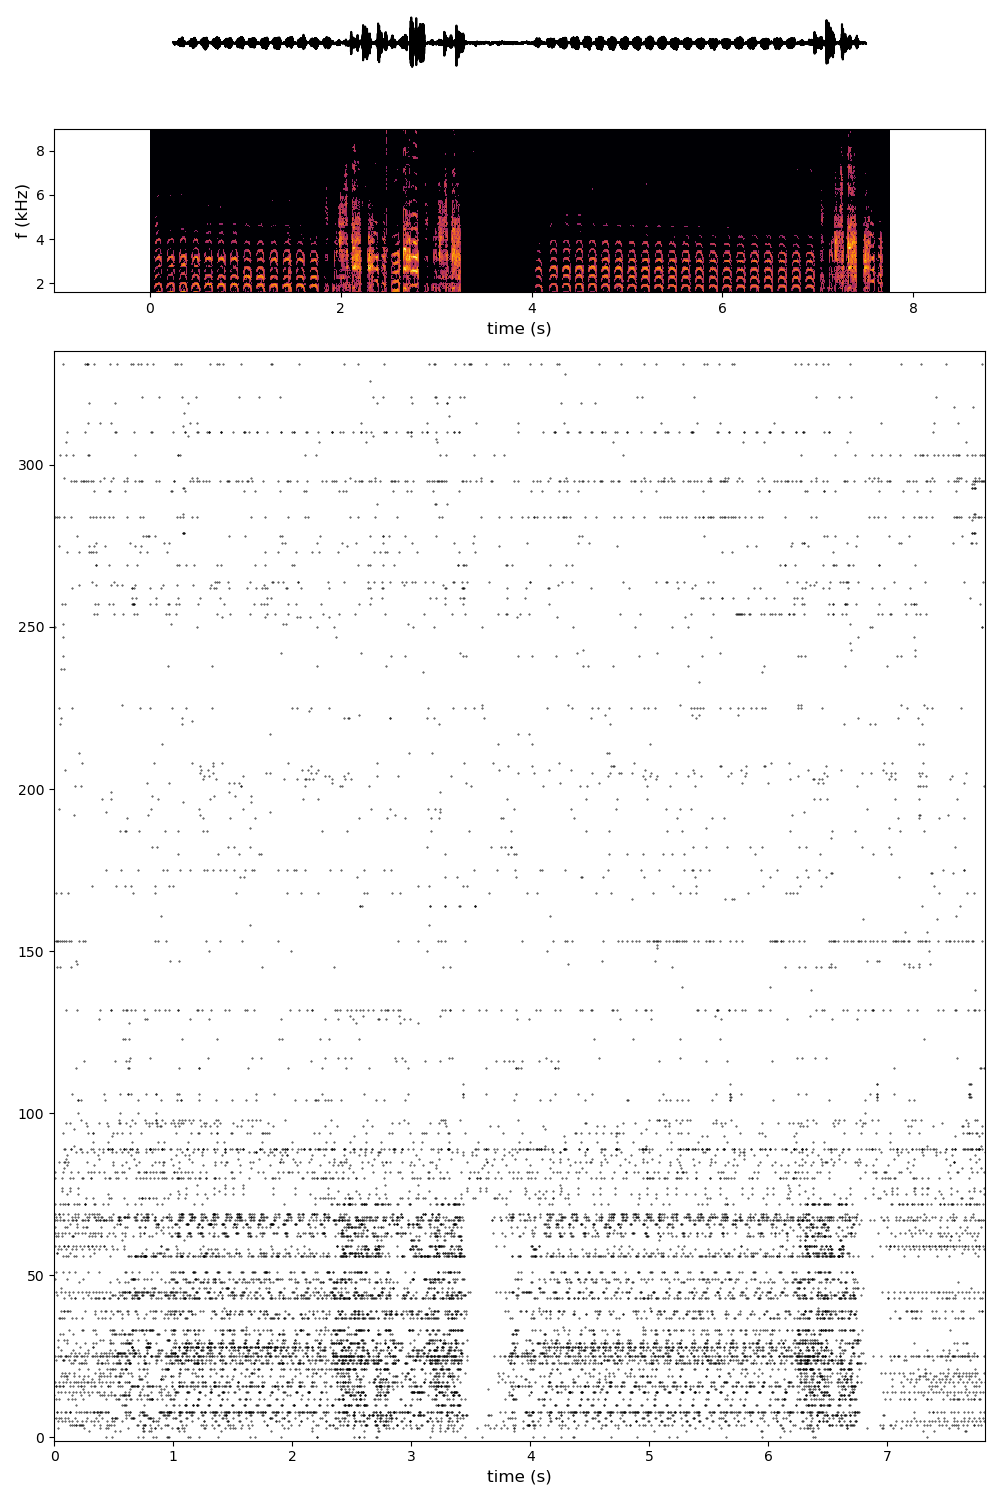

In [423]:
# plot bout with raster
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 3, 20]}, figsize=(10, 15))

# plot sonogram
ax[0].plot(waveform.flatten(), 'black')
ax[0].set_xlim([-trail_front*bout_fs, len(waveform.flatten())+trail_end*bout_fs])
ax[0].set_axis_off()

# plot spectrogram
f, t, sxx = make_spec(waveform.flatten(), fs)
ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax[1].set_xlim([-trail_front, t[-1]+trail_end])
ax[1].tick_params(axis='x', labelsize=10)
ax[1].set_ylabel('f (kHz)', fontsize=12)
ax[1].set_yticks([0,2000, 4000, 6000, 8000])
ax[1].set_yticklabels(['0', '2', '4', '6', '8'], fontsize=10)
ax[1].set_ylim([500, 9000])

# plot spike raster
x_trial, x_time = np.where(spike_arr>0)
ax[2].plot(x_time, x_trial, '.', color='k', markersize=0.75, rasterized=True)
ax[2].set_xlim(0, spike_arr.shape[1])
ax[2].set_ylim(-1, spike_arr.shape[0] + 1)
ax[2].set_xticks(np.arange(0, spike_arr.shape[1], fs).tolist())
ax[2].set_xticklabels([str(int(e)) for e in np.arange(0,np.ceil(spike_arr.shape[1]/fs))])
ax[2].set_xlabel('Time (s)', fontsize=12)
ax[3].set_ylabel('Neuron', fontsize=12)
plt.tight_layout()